In [4]:
import os
import cv2 as cv
import numpy
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
assert torch.cuda.is_available() == True
torch.device('cuda')
device = 'cuda'

In [6]:
p = os.listdir('data/images')
len(p)

7864

In [7]:
m, s = (.5, .5, .5), (.5, .5, .5)
ds = ImageFolder('data', tt.Compose([
                    tt.Resize(64), 
                    tt.CenterCrop(64),
                    tt.RandomHorizontalFlip(),
                    tt.ToTensor(),
                    tt.Normalize(m, s)
                ]))

train_dl = DataLoader(ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

In [8]:
def denorm(img_tensor):
    return img_tensor*s[0] + m[0]

def show_image(im, nmax=64):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(im.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for im, _ in dl:
        show_image(im, nmax)
        break

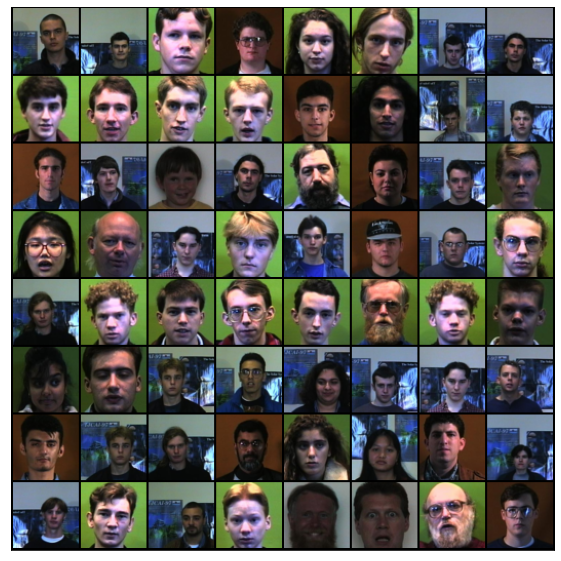

In [9]:
show_batch(train_dl)

In [10]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,'cuda')
    def __len__(self):
        return len(self.dl)

In [11]:
train_dl = DeviceDataLoader(train_dl,device)

In [12]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator,device)

In [15]:
latent_size = 128
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)
generator = to_device(generator, device)

torch.Size([64, 3, 64, 64])


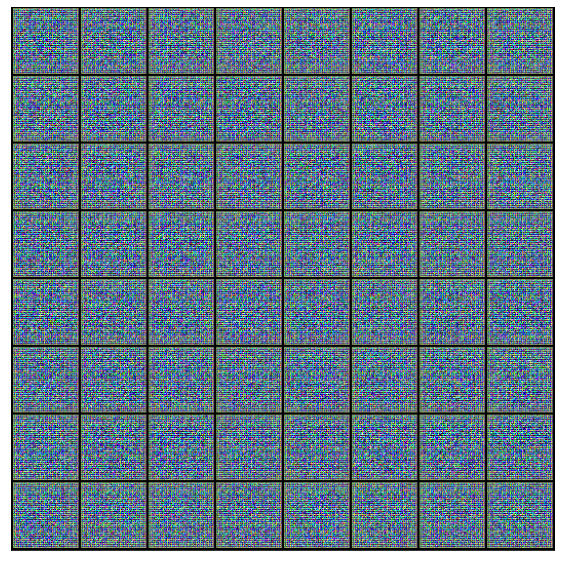

In [14]:
xb = torch.randn(64,latent_size,1,1)
fake_image = generator(xb)
print(fake_image.shape)
show_image(fake_image)

In [16]:
def train_discriminator(real_images, opt_d, batch_size=64):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [17]:
def train_generator(opt_g, batch_size=64):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [18]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [19]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    print(fake_images.size())
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [20]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
fixed_latent.shape

torch.Size([64, 128, 1, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 64, 64])
Saving generated-images-0000.png


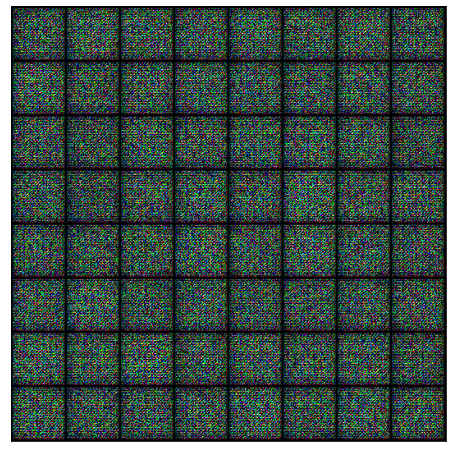

In [21]:
save_samples(0, fixed_latent)

In [25]:
def train_both(epochs, lr, start_idx=1):    
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in train_dl:
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [26]:
lr=0.0002
epochs=60
history = train_both(epochs, lr)

Epoch [1/60], loss_g: 7.1771, loss_d: 0.0187, real_score: 0.9901, fake_score: 0.0080
torch.Size([64, 3, 64, 64])
Saving generated-images-0001.png
Epoch [2/60], loss_g: 6.8293, loss_d: 0.0197, real_score: 0.9930, fake_score: 0.0125
torch.Size([64, 3, 64, 64])
Saving generated-images-0002.png
Epoch [3/60], loss_g: 6.8528, loss_d: 0.0041, real_score: 0.9977, fake_score: 0.0019
torch.Size([64, 3, 64, 64])
Saving generated-images-0003.png
Epoch [4/60], loss_g: 7.2396, loss_d: 0.0047, real_score: 0.9974, fake_score: 0.0021
torch.Size([64, 3, 64, 64])
Saving generated-images-0004.png
Epoch [5/60], loss_g: 6.7209, loss_d: 0.0421, real_score: 0.9884, fake_score: 0.0295
torch.Size([64, 3, 64, 64])
Saving generated-images-0005.png
Epoch [6/60], loss_g: 3.6665, loss_d: 0.1956, real_score: 0.9506, fake_score: 0.1282
torch.Size([64, 3, 64, 64])
Saving generated-images-0006.png
Epoch [7/60], loss_g: 6.7306, loss_d: 0.0509, real_score: 0.9590, fake_score: 0.0021
torch.Size([64, 3, 64, 64])
Saving gene

Exception ignored in: <function tqdm.__del__ at 0x000001D40868E828>
Traceback (most recent call last):
  File "c:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\std.py", line 1147, in __del__
    self.close()
  File "c:\Users\tg584\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Epoch [31/60], loss_g: 6.3104, loss_d: 0.1418, real_score: 0.9824, fake_score: 0.0884
torch.Size([64, 3, 64, 64])
Saving generated-images-0031.png
Epoch [32/60], loss_g: 5.4892, loss_d: 0.0374, real_score: 0.9940, fake_score: 0.0299
torch.Size([64, 3, 64, 64])
Saving generated-images-0032.png
Epoch [33/60], loss_g: 4.1027, loss_d: 0.0619, real_score: 0.9668, fake_score: 0.0250
torch.Size([64, 3, 64, 64])
Saving generated-images-0033.png
Epoch [34/60], loss_g: 4.9723, loss_d: 0.0436, real_score: 0.9898, fake_score: 0.0312
torch.Size([64, 3, 64, 64])
Saving generated-images-0034.png
Epoch [35/60], loss_g: 6.2242, loss_d: 0.0868, real_score: 0.9459, fake_score: 0.0242
torch.Size([64, 3, 64, 64])
Saving generated-images-0035.png
Epoch [36/60], loss_g: 5.1566, loss_d: 0.0398, real_score: 0.9727, fake_score: 0.0113
torch.Size([64, 3, 64, 64])
Saving generated-images-0036.png
Epoch [37/60], loss_g: 4.0324, loss_d: 0.0594, real_score: 0.9729, fake_score: 0.0302
torch.Size([64, 3, 64, 64])
Savi

In [27]:
losses_g, losses_d, real_scores, fake_scores = history

Text(0.5, 1.0, 'Losses')

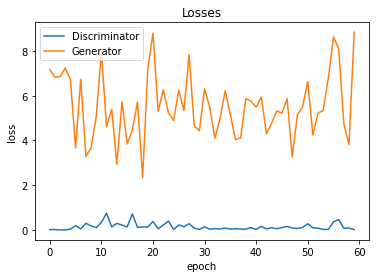

In [28]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

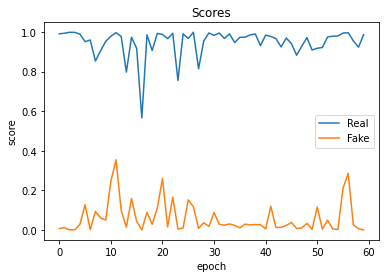

In [29]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')